![](https://i.hizliresim.com/f9tyw59.png)

## Bussines Problem
    
**Predicting which class (average, highlighted) player is according to the points given to the characteristics of the players. (Scenario)**

## Dataset Story
**The data set consists of information from Scoutium, which includes the features and scores of the football players evaluated by the scouts according to the characteristics of the footballers observed in the matches.**

<strong><h3>Scoutium Attributes CSV File</h3><p>

---
<li><strong>Total Features : 8</strong></li>
<li><strong>Total Row : 10.730</strong> </li>
<li><strong>CSV File Size : 527 KB</strong></li>
    
---
    
   Sr. | Feature  | Description |
--- | --- | --- 
1 | task_response_id | The set of a scout's assessments of all players on a team's roster in a match
2 | match_id | The id of the match
3 | evaluator_id | The id of the evaluator(scout)
4 | player_id | The id of the player
5 | position_id | The id of the position played by the relevant player in that match. 1-Goalkeeper, 2-Stopper, 3-Right-back, 4-Left-back, 5-Defensive midfielder, 6-Central midfield, 7-Right wing, 8-Left wing, 9-Attacking midfielder, 10-Striker
6 | analysis_id | A set containing a scout's attribute evaluations of a player in a match
7 | attribute_id | The id of each attribute the players were evaluated for
8 | attribute_value | Value (points) given by a scout to a player's attribute

<strong><h3>Scoutium Potential Labels CSV File</h3><p>
    
---
<li><strong>Total Features : 5</strong></li>
<li><strong>Total Row : 322</strong> </li>
<li><strong>CSV File Size : 12 KB</strong></li>
    
---
    
Sr. | Feature  | Description |
--- | --- | --- 
1 | task_response_id | The set of a scout's assessments of all players on a team's roster in a match
2 | match_id | The id of the match
3 | evaluator_id | The id of the evaluator(scout)
4 | player_id | The id of the player
5 | potential_label | Label showing the final decision of an observer regarding a player in the match. (target variable)


## Project

In [355]:
import warnings
import time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna
from optuna.samplers import TPESampler

In [356]:
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=Warning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [357]:
attr_df = pd.read_csv("/kaggle/input/scoutium/scoutium_attributes.csv", sep=";")

In [358]:
potential_df = pd.read_csv("/kaggle/input/scoutium/scoutium_potential_labels.csv", sep=";")

In [359]:
attr_df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.0
1,4915,62935,177676,1361061,2,12818495,4323,56.0
2,4915,62935,177676,1361061,2,12818495,4324,67.0
3,4915,62935,177676,1361061,2,12818495,4325,56.0
4,4915,62935,177676,1361061,2,12818495,4326,45.0


In [360]:
potential_df.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [361]:
df = pd.merge(attr_df, potential_df, how="left", on=["task_response_id", "match_id", "evaluator_id", "player_id"])

In [362]:
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [363]:
#I'm removing the Position Id 1(Goalkeeper) from the dataset.
df = df[~(df["position_id"] == 1)]

In [364]:
df["position_id"].value_counts()

2     1972
6     1428
10    1088
8     1020
7      986
3      986
4      884
9      850
5      816
Name: position_id, dtype: int64

In [365]:
df["potential_label"].value_counts()

average          7922
highlighted      1972
below_average     136
Name: potential_label, dtype: int64

In [366]:
# I am deleting from the dataset of the below_average variable.
df = df[~(df["potential_label"] == "below_average")]

In [367]:
df["potential_label"].value_counts()

average        7922
highlighted    1972
Name: potential_label, dtype: int64

## Data Analysis

In [368]:
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [369]:
print(f"The shape of DataFrame is:{df.shape}")

The shape of DataFrame is:(9894, 9)


In [370]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9894 entries, 0 to 10729
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   task_response_id  9894 non-null   int64  
 1   match_id          9894 non-null   int64  
 2   evaluator_id      9894 non-null   int64  
 3   player_id         9894 non-null   int64  
 4   position_id       9894 non-null   int64  
 5   analysis_id       9894 non-null   int64  
 6   attribute_id      9894 non-null   int64  
 7   attribute_value   9894 non-null   float64
 8   potential_label   9894 non-null   object 
dtypes: float64(1), int64(7), object(1)
memory usage: 773.0+ KB


In [371]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
task_response_id,9894.0,5.253674e+03,268.121545,4915.0,4997.0,5162.0,5524.0,5642.0
match_id,9894.0,6.319909e+04,666.084991,60549.0,62988.0,63166.0,63627.0,64045.0
evaluator_id,9894.0,1.752841e+05,43563.191062,130478.0,151191.0,151191.0,177676.0,256441.0
player_id,9894.0,1.528313e+06,203116.033452,1355710.0,1367783.0,1372673.0,1719653.0,1909728.0
position_id,9894.0,5.642612e+00,2.707408,2.0,3.0,6.0,8.0,10.0
analysis_id,9894.0,1.282241e+07,2673.435835,12818484.0,12819582.0,12822231.0,12825047.0,12825763.0
attribute_id,9894.0,4.348676e+03,26.848112,4322.0,4330.0,4342.5,4353.0,4426.0
attribute_value,9894.0,5.552193e+01,15.942053,1.0,45.0,56.0,67.0,100.0


In [372]:
df["attribute_value"].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

0.00      1.0
0.05     23.0
0.50     56.0
0.95     78.0
0.99     78.0
1.00    100.0
Name: attribute_value, dtype: float64

In [373]:
df.isnull().sum()

task_response_id    0
match_id            0
evaluator_id        0
player_id           0
position_id         0
analysis_id         0
attribute_id        0
attribute_value     0
potential_label     0
dtype: int64

In [374]:
df["potential_label"].value_counts()

average        7922
highlighted    1972
Name: potential_label, dtype: int64

In [375]:
df.groupby('potential_label').aggregate({'attribute_value' : 'mean' })

,attribute_value
potential_label,
average,54.528149
highlighted,59.514199


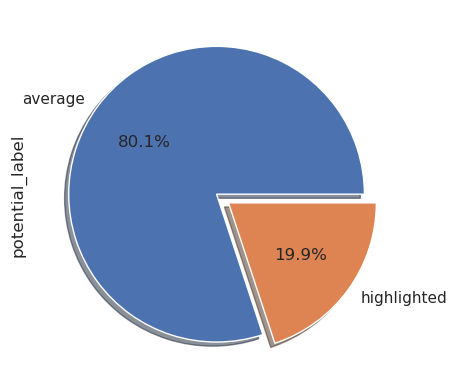

In [376]:
df["potential_label"].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True)
plt.show()

## Creation of Player DataFrame

In [377]:
# I'm manipulating the data so that there is one player per row.
player_df = df.pivot_table(index=["player_id", "position_id", "potential_label"], 
                           columns= "attribute_id", 
                           values="attribute_value")

In [378]:
player_df.head()

attribute_id                           4322  4323  4324  4325  4326  4327  \
player_id position_id potential_label                                       
1355710   7           average          50.5  50.5  34.0  50.5  45.0  45.0   
1356362   9           average          67.0  67.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  67.0  67.0  67.0  67.0  67.0   
          4           average          67.0  78.0  67.0  67.0  67.0  78.0   
1356411   9           average          67.0  67.0  78.0  78.0  67.0  67.0   

attribute_id                           4328  4329  4330  4332  4333  4335  \
player_id position_id potential_label                                       
1355710   7           average          45.0  45.0  50.5  56.0  39.5  34.0   
1356362   9           average          67.0  67.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  78.0  67.0  67.0  78.0  56.0   
          4           average          78.0  78.0  56.0  67.0  67.0  67.0   
1356411   9           average          67.0  67.0  89.0  78.0  67.0  67.0   

attribute_id                           4338  4339  4340  4341  4342  4343  \
player_id position_id potential_label                                       
1355710   7           average          39.5  39.5  45.0  45.0  50.5  28.5   
1356362   9           average          67.0  67.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  67.0  67.0  67.0  67.0  56.0   
          4           average          78.0  78.0  56.0  67.0  67.0  45.0   
1356411   9           average          67.0  56.0  56.0  67.0  78.0  56.0   

attribute_id                           4344  4345  4348  4349  4350  4351  \
player_id position_id potential_label                                       
1355710   7           average          23.0  39.5  28.5  28.5  45.0  50.5   
1356362   9           average          56.0  67.0  67.0  56.0  67.0  67.0   
1356375   3           average          56.0  67.0  67.0  56.0  56.0  67.0   
          4           average          45.0  56.0  67.0  67.0  67.0  67.0   
1356411   9           average          56.0  67.0  56.0  67.0  56.0  67.0   

attribute_id                           4352  4353  4354  4355  4356  4357  \
player_id position_id potential_label                                       
1355710   7           average          56.0  34.0  39.5  50.5  34.0  34.0   
1356362   9           average          67.0  67.0  78.0  67.0  67.0  67.0   
1356375   3           average          67.0  67.0  78.0  67.0  67.0  67.0   
          4           average          78.0  67.0  67.0  67.0  56.0  67.0   
1356411   9           average          67.0  56.0  67.0  67.0  56.0  67.0   

attribute_id                           4407  4408  4423  4426  
player_id position_id potential_label                          
1355710   7           average          56.0  34.0  34.0  56.0  
1356362   9           average          67.0  67.0  56.0  78.0  
1356375   3           average          67.0  67.0  56.0  78.0  
          4           average          56.0  67.0  45.0  56.0  
1356411   9           average          89.0  56.0  67.0  78.0

In [379]:
player_df.reset_index(inplace=True)

In [380]:
# I am converting the type of columns to string.
player_df.columns = player_df.columns.map(str)
player_df.columns.name = None

In [381]:
player_df.head()

,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.5,50.5,34.0,50.5,45.0,45.0,45.0,45.0,50.5,56.0,39.5,34.0,39.5,39.5,45.0,45.0,50.5,28.5,23.0,39.5,28.5,28.5,45.0,50.5,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,56.0,67.0,67.0,67.0,67.0,67.0,56.0,56.0,67.0,67.0,56.0,56.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,average,67.0,78.0,67.0,67.0,67.0,78.0,78.0,78.0,56.0,67.0,67.0,67.0,78.0,78.0,56.0,67.0,67.0,45.0,45.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,average,67.0,67.0,78.0,78.0,67.0,67.0,67.0,67.0,89.0,78.0,67.0,67.0,67.0,56.0,56.0,67.0,78.0,56.0,56.0,67.0,56.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


### Encoding

In [382]:
# I am applying LabelEncoder operation to potential_label variable.
le = LabelEncoder()
player_df["potential_label"] = le.fit_transform(player_df["potential_label"])

In [383]:
player_df.head()

,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.5,50.5,34.0,50.5,45.0,45.0,45.0,45.0,50.5,56.0,39.5,34.0,39.5,39.5,45.0,45.0,50.5,28.5,23.0,39.5,28.5,28.5,45.0,50.5,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,56.0,67.0,67.0,67.0,67.0,67.0,56.0,56.0,67.0,67.0,56.0,56.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,0,67.0,78.0,67.0,67.0,67.0,78.0,78.0,78.0,56.0,67.0,67.0,67.0,78.0,78.0,56.0,67.0,67.0,45.0,45.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,67.0,89.0,78.0,67.0,67.0,67.0,56.0,56.0,67.0,78.0,56.0,56.0,67.0,56.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


In [384]:
num_cols = [col for col in player_df.columns if col not in ["player_id", "position_id", "potential_label"]]

In [385]:
player_df[num_cols]

,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,50.5,50.5,34.0,50.5,45.0,45.0,45.0,45.0,50.5,56.0,39.5,34.0,39.5,39.5,45.0,45.0,50.5,28.5,23.0,39.5,28.5,28.5,45.0,50.5,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,56.0,67.0,67.0,67.0,67.0,67.0,56.0,56.0,67.0,67.0,56.0,56.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,67.0,78.0,67.0,67.0,67.0,78.0,78.0,78.0,56.0,67.0,67.0,67.0,78.0,78.0,56.0,67.0,67.0,45.0,45.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,67.0,67.0,78.0,78.0,67.0,67.0,67.0,67.0,89.0,78.0,67.0,67.0,67.0,56.0,56.0,67.0,78.0,56.0,56.0,67.0,56.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,67.0,78.0,78.0,56.0,78.0,67.0,78.0,67.0,56.0,78.0,78.0,56.0,67.0,67.0,78.0,56.0,67.0,56.0,56.0,67.0,78.0,89.0,67.0,78.0,67.0,67.0,67.0,67.0,56.0,67.0,78.0,78.0,78.0,56.0
267,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,56.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0
268,56.0,45.0,45.0,45.0,56.0,56.0,56.0,56.0,23.0,23.0,34.0,45.0,56.0,34.0,23.0,45.0,45.0,23.0,23.0,34.0,23.0,23.0,34.0,23.0,45.0,45.0,56.0,34.0,34.0,56.0,34.0,34.0,34.0,23.0
269,78.0,78.0,78.0,78.0,78.0,78.0,78.0,78.0,67.0,67.0,78.0,78.0,78.0,67.0,78.0,67.0,78.0,56.0,56.0,78.0,78.0,67.0,78.0,78.0,78.0,78.0,78.0,67.0,67.0,67.0,78.0,78.0,67.0,78.0


### Correlation Map

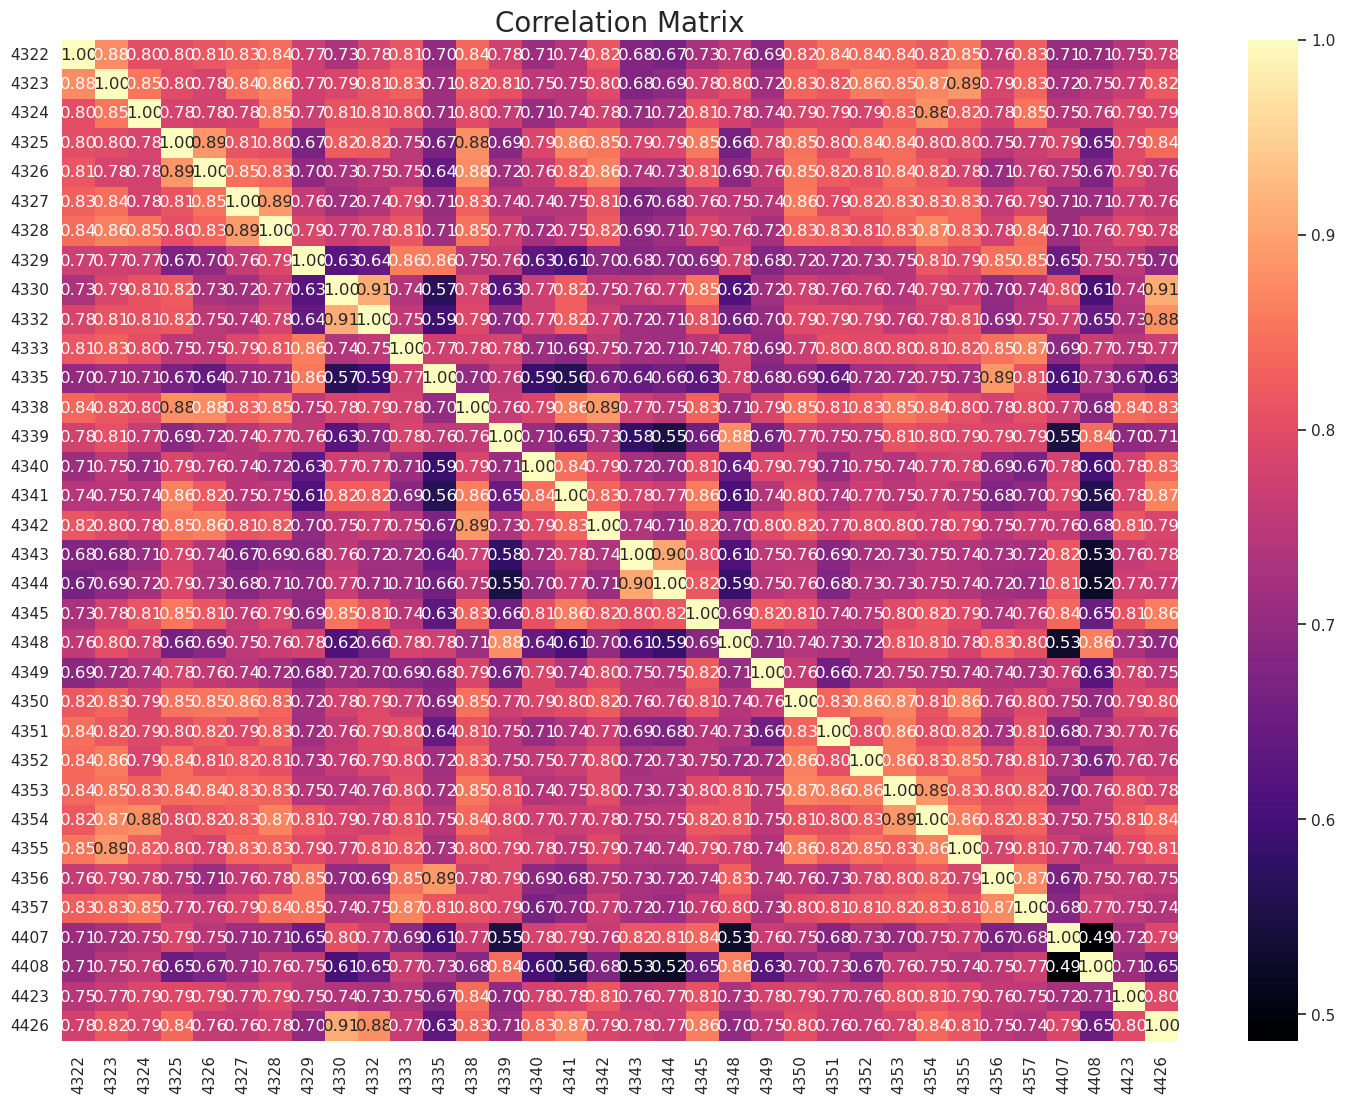

In [386]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(player_df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

### Standart Scaler

In [387]:
# I am implementing the StandardScaler operation for numeric columns.
player_df[num_cols] = StandardScaler().fit_transform(player_df[num_cols])

In [388]:
player_df.head()

,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.542606,-0.559398,-1.404764,-0.437916,-0.766602,-0.794802,-0.907351,-0.791605,-0.446324,-0.122619,-1.223858,-1.035633,-1.126240,-1.009285,-0.541797,-0.690375,-0.535091,-1.067288,-1.205671,-1.004927,-1.313773,-1.041775,-0.693269,-0.435633,0.012848,-1.281899,-1.132245,-0.494569,-1.234869,-1.519578,-0.142650,-1.487256,-0.955381,-0.252741
1,1356362,9,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,0.404075,0.727985,0.691171,0.459154,0.996474,0.631888,0.840464,0.911936,0.799406,0.588047,1.229965,0.749536,0.742305,0.878802,0.669953,0.847750,0.716763,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
2,1356375,3,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,1.001915,0.727985,0.691171,1.132359,0.319105,0.631888,0.840464,0.911936,0.799406,0.588047,0.573607,0.749536,0.742305,0.878802,0.669953,0.077240,0.716763,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
3,1356375,4,0,0.595327,1.307560,0.678677,0.682837,0.722639,1.481795,1.355461,1.001915,-0.054888,0.691171,0.459154,0.996474,1.335139,1.580363,0.185069,0.799406,0.588047,-0.082751,0.097800,0.043412,0.878802,1.354645,0.847750,0.716763,1.560314,0.813645,0.428479,0.631718,0.198319,0.768231,-0.142650,0.668713,-0.275832,-0.252741
4,1356411,9,0,0.595327,0.560776,1.373158,1.430006,0.722639,0.722929,0.601190,0.404075,2.293730,1.504961,0.459154,0.996474,0.631888,0.100564,0.185069,0.799406,1.336806,0.573607,0.749536,0.742305,0.252352,1.354645,0.077240,0.716763,0.786581,0.115130,0.428479,0.631718,0.198319,0.768231,1.874292,-0.049944,1.083267,1.041611


In [389]:
player_df.describe().T

,count,mean,std,min,25%,50%,75%,max
player_id,271.0,1.538155e+06,204999.320677,1.355710e+06,1.368264e+06,1.373419e+06,1.720508e+06,1.909728e+06
position_id,271.0,5.627306e+00,2.689732,2.000000e+00,3.000000e+00,6.000000e+00,8.000000e+00,1.000000e+01
potential_label,271.0,2.066421e-01,0.405646,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
4322,271.0,-8.521269e-17,1.001850,-2.439163e+00,-9.219178e-01,-1.632952e-01,5.953275e-01,2.112573e+00
4323,271.0,-5.899340e-17,1.001850,-2.426356e+00,-9.327901e-01,-1.860069e-01,5.607763e-01,2.054343e+00
4324,271.0,-2.982444e-16,1.001850,-2.099244e+00,-7.102834e-01,-1.580306e-02,6.786773e-01,1.373158e+00
4325,271.0,3.932893e-16,1.001850,-3.053008e+00,-8.115010e-01,3.092527e-01,6.828372e-01,2.177175e+00
4326,271.0,1.835350e-16,1.001850,-2.255844e+00,-7.666021e-01,3.503289e-01,7.226393e-01,2.211881e+00
4327,271.0,1.310964e-17,1.001850,-2.312533e+00,-7.948019e-01,-3.593644e-02,7.229291e-01,1.481795e+00
4328,271.0,2.621929e-17,1.001850,-2.415893e+00,-9.073514e-01,-1.530808e-01,6.011899e-01,2.109731e+00


## Modelling

In [390]:
y = player_df["potential_label"]
X = player_df.drop(["player_id", "potential_label"], axis=1)

In [391]:
print(f"The Shape of X is --> {X.shape}")
print(f"The Shape of y is --> {y.shape}")

The Shape of X is --> (271, 35)
The Shape of y is --> (271,)


In [392]:
models = [
    ("LR", LogisticRegression()),
    ("KNN", KNeighborsClassifier()),
    ("CART", DecisionTreeClassifier()),
    ("RF", RandomForestClassifier()),
    ("GBM", GradientBoostingClassifier()),
    ("XGB", XGBClassifier()),
    ("LGBM", LGBMClassifier()),
    ("CAT", CatBoostClassifier(verbose=False)),
]

In [393]:
for name, model in models:
    print(name)
    start = time.time()
    for score in ["accuracy", "precision", "recall", "f1"]:
        scores = cross_validate(model, X, y, cv=10, scoring=score)
        print(score, ":", scores["test_score"].mean())
    end = time.time()
    print("runtime: %.2f s"%(end - start))
    print("-" * 20)

LR
accuracy : 0.8525132275132276
precision : 0.7738095238095238
recall : 0.49000000000000005
f1 : 0.5684648684648684
runtime: 1.06 s
--------------------
KNN
accuracy : 0.8449735449735449
precision : 0.775
recall : 0.30999999999999994
f1 : 0.4278571428571428
runtime: 0.27 s
--------------------
CART
accuracy : 0.7970899470899472
precision : 0.585
recall : 0.5366666666666666
f1 : 0.5440692640692639
runtime: 0.26 s
--------------------
RF
accuracy : 0.8855820105820106
precision : 0.9583333333333334
recall : 0.43999999999999995
f1 : 0.593001443001443
runtime: 6.99 s
--------------------
GBM
accuracy : 0.8560846560846562
precision : 0.7266666666666667
recall : 0.47000000000000003
f1 : 0.6226878676878677
runtime: 4.65 s
--------------------
XGB
accuracy : 0.8563492063492063
precision : 0.7397619047619048
recall : 0.5766666666666665
f1 : 0.611030081030081
runtime: 10.81 s
--------------------
LGBM
accuracy : 0.8817460317460318
precision : 0.8071428571428572
recall : 0.5933333333333333
f1 : 0

**The best model is the LightGBM model. I continue my way with LightGBM.**

In [394]:
def model_score(y_test, pred, proba):
    print(f"Accuracy Score: {accuracy_score(y_test, pred)}")
    print(f"Roc-Auc Score: {roc_auc_score(y_test, proba)}")
    print(f"F1 Score: {f1_score(y_test, pred)}")

In [395]:
model = LGBMClassifier(random_state=31)

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=31)

In [397]:
print(f"The shape of X_train is --> {X_train.shape}")
print(f"The shape of X_test is  --> {X_test.shape}")
print(f"The shape of y_train is --> {y_train.shape}")
print(f"The shape of y_test is  --> {y_test.shape}")

The shape of X_train is --> (216, 35)
The shape of X_test is  --> (55, 35)
The shape of y_train is --> (216,)
The shape of y_test is  --> (55,)


In [398]:
model.fit(X_train, y_train)

LGBMClassifier(random_state=31)

In [399]:
pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:,-1]

In [400]:
model_score(y_test, pred, proba)

Accuracy Score: 0.8363636363636363
Roc-Auc Score: 0.8362369337979094
F1 Score: 0.5714285714285714


In [401]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90        41
           1       0.86      0.43      0.57        14

    accuracy                           0.84        55
   macro avg       0.85      0.70      0.74        55
weighted avg       0.84      0.84      0.82        55



In [402]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 31,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

## Optuna Optimization 

In [403]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_loguniform("subsample", 0.01, 1),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.01, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.01, 1),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 0.01, 1),
        "random_state": 31,
    }
    
    gbm = LGBMClassifier(**params)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    return accuracy

In [404]:
sampler = TPESampler(seed=1)

In [405]:
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)

In [406]:
study.optimize(objective, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [407]:
study.best_params

{'n_estimators': 846,
 'learning_rate': 0.6585389834771244,
 'num_leaves': 73,
 'min_child_samples': 43,
 'max_depth': 4,
 'subsample': 0.011160959413782727,
 'colsample_bytree': 0.01221624836149229,
 'reg_alpha': 0.4543241810180315,
 'reg_lambda': 0.18257876894702296}

In [408]:
study.best_value

0.8727272727272727

In [409]:
study.best_trial

FrozenTrial(number=72, state=TrialState.COMPLETE, values=[0.8727272727272727], datetime_start=datetime.datetime(2023, 3, 10, 16, 22, 28, 687530), datetime_complete=datetime.datetime(2023, 3, 10, 16, 22, 29, 153124), params={'n_estimators': 846, 'learning_rate': 0.6585389834771244, 'num_leaves': 73, 'min_child_samples': 43, 'max_depth': 4, 'subsample': 0.011160959413782727, 'colsample_bytree': 0.01221624836149229, 'reg_alpha': 0.4543241810180315, 'reg_lambda': 0.18257876894702296}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=5, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'subsample': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'colsample_bytr

### Building Final Model

In [410]:
final_model = LGBMClassifier(**study.best_params, random_state=31)

In [411]:
final_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.01221624836149229,
               learning_rate=0.6585389834771244, max_depth=4,
               min_child_samples=43, n_estimators=846, num_leaves=73,
               random_state=31, reg_alpha=0.4543241810180315,
               reg_lambda=0.18257876894702296, subsample=0.011160959413782727)

In [412]:
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:,-1]

In [413]:
model_score(y_test, y_pred, y_prob)

Accuracy Score: 0.8727272727272727
Roc-Auc Score: 0.8466898954703832
F1 Score: 0.6666666666666666


In [414]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        41
           1       1.00      0.50      0.67        14

    accuracy                           0.87        55
   macro avg       0.93      0.75      0.79        55
weighted avg       0.89      0.87      0.86        55



In [415]:
result_df = pd.DataFrame({"Real": y_test, "Predicted": y_pred})

In [416]:
result_df.head()

,Real,Predicted
102,0,0
80,0,0
245,1,0
173,0,0
17,0,0


In [417]:
result_df[result_df["Real"] != result_df["Predicted"]]

,Real,Predicted
245,1,0
183,1,0
142,1,0
20,1,0
88,1,0
53,1,0
206,1,0


**As a result of model tests, I realized that there was a bias. The true values of the wrong predictions all consist of the class "1". This situation may have been caused by the class imbalance in the data set. In this case, we need to correct the class imbalance in the dataset to improve the performance of the model. For this, we can equalize the number of classes in the data set. I will use the *Oversampling method* to do this.**

In [418]:
y_train.value_counts()

0    174
1     42
Name: potential_label, dtype: int64

In [419]:
y_test.value_counts()

0    41
1    14
Name: potential_label, dtype: int64

## Oversampling Method

In [420]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

In [421]:
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [422]:
y_train.value_counts()

1    174
0    174
Name: potential_label, dtype: int64

In [423]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [424]:
randomover_model = LGBMClassifier(**study.best_params, random_state=31)

In [425]:
randomover_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.13184124961216806,
               learning_rate=0.014611512297464059, max_depth=8,
               min_child_samples=16, n_estimators=343, num_leaves=85,
               random_state=31, reg_alpha=0.2855021123011533,
               reg_lambda=0.018854574969337227, subsample=0.21327803857892996)

In [426]:
y_pred = randomover_model.predict(X_test)
y_prob = randomover_model.predict_proba(X_test)[:,-1]

In [427]:
model_score(y_test, y_pred,y_prob)

Accuracy Score: 0.8909090909090909
Roc-Auc Score: 0.837979094076655
F1 Score: 0.7272727272727273


In [428]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        41
           1       1.00      0.57      0.73        14

    accuracy                           0.89        55
   macro avg       0.94      0.79      0.83        55
weighted avg       0.90      0.89      0.88        55



In [429]:
result_df = pd.DataFrame({"Real": y_test, "Predicted": y_pred})

In [430]:
result_df.head()

,Real,Predicted
102,0,0
80,0,0
245,1,0
173,0,0
17,0,0


In [431]:
result_df[result_df["Real"] != result_df["Predicted"]]

,Real,Predicted
245,1,0
183,1,0
142,1,0
20,1,0
88,1,0
206,1,0


**After applying the oversampling method, the performance of our model has increased.**

## Feature Importances

In [432]:
feature_imp_final = pd.DataFrame({'Value': final_model.feature_importances_, 'Feature': X_train.columns})
feature_imp_randomover = pd.DataFrame({'Value': randomover_model.feature_importances_, 'Feature': X_train.columns})

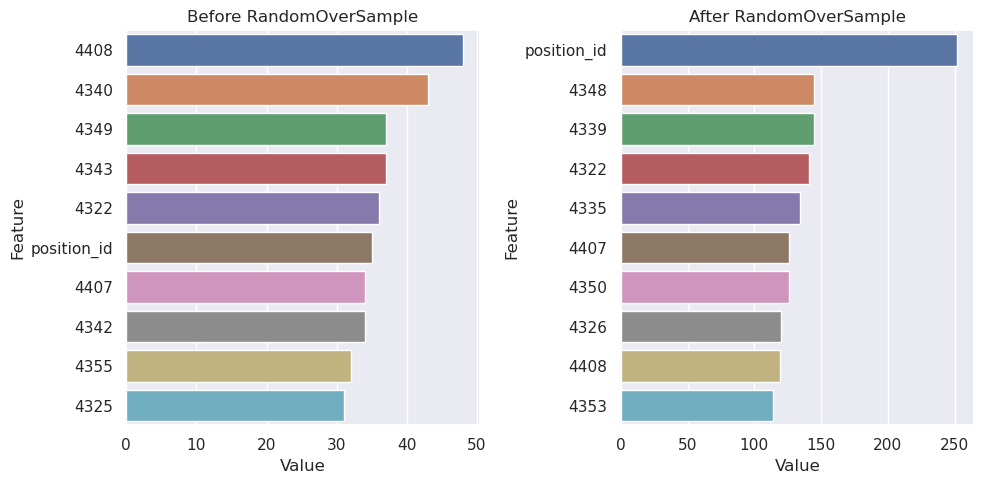

In [433]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
sns.set(font_scale=1)
sns.barplot(x="Value", y="Feature", data=feature_imp_final.sort_values(by="Value", ascending=False)[0:10], ax=ax[0], label="Final Model")
sns.barplot(x="Value", y="Feature", data=feature_imp_randomover.sort_values(by="Value", ascending=False)[0:10], ax=ax[1], label="RandomOverSampler Model")
ax[0].set_title("Before RandomOverSample")
ax[1].set_title("After RandomOverSample")
plt.tight_layout()
plt.show()